In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as so
from uncertainties import ufloat

In [41]:
Calibration_Data = pd.read_excel('lab 3 calibration.xlsx',header=1)
Week_2_Data = pd.read_excel('trial1 data.xlsx',header=0)
Week_2_small_pd = pd.read_excel('trail1 small.xlsx',header=1)
Week_3_pd = pd.read_excel('lab week 3.xlsx',header=1)

Calibration_Data_array = np.array(Calibration_Data)
Week_2_large = np.array(Week_2_Data)
Week_2_small = np.array(Week_2_small_pd)
Week_3 = np.array([Week_3_pd]).reshape(2069,38)
del(Calibration_Data,Week_2_Data,Week_2_small_pd)

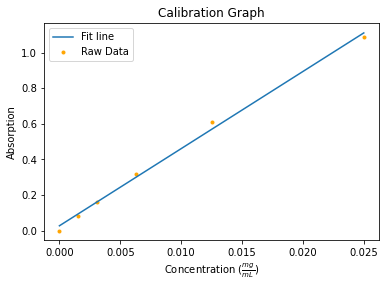

In [42]:
def fit_linear(t, y):
    P, cov = np.polyfit(t, y, 1,cov=True)
    error = np.sqrt(np.diag(cov))
    return P, error

def rsquared(x,y,yfit):
    ymean=np.mean(y)
    sstot=sum((y-ymean)**2)
    ssres=sum((y-yfit)**2)
    rs=1-ssres/sstot
    return rs

def data_deriv(y,x):
    h=x[1]-x[0]
    dydx=np.zeros(y.shape)
    dydx[0]=(-3*y[0]+4*y[1]-y[2])/(2*h)
    dydx[-1]=(3*y[-1]-4*y[-2]+y[-3])/(2*h)
    dydx[1:-1]=(y[2:]-y[:-2])/(2*h)
    return dydx

CDA = Calibration_Data_array
cali = np.array([[[0,0]]])
for i in range(0,5):
    idx = np.where(CDA[:,4+3*i] == np.max(CDA[:,4+3*i]))
    Point = CDA[idx,3*(i+1):3*(i+1)+2]
    cali = np.vstack((cali,Point))
cali = cali.reshape(6,2)

concentration = np.array([0,0.0015625,0.003125,0.00625,0.0125,0.025])

Param,error = fit_linear(concentration,cali[:,1])
step = 0.000001
conc = np.arange(0,np.max(concentration)+step,step)
y_new = Param[0]*conc+Param[1]

fit = rsquared(concentration,cali[:,1],Param[0]*concentration+Param[1])

plt.figure()
plt.scatter(concentration,cali[:,1],c='orange',marker='.',label ='Raw Data')
plt.plot(conc,y_new,label ='Fit line')
plt.ylabel('Absorption')
plt.xlabel('Concentration ($\\frac{mg}{mL}$)')
plt.title('Calibration Graph')
plt.legend()
plt.show()

In [43]:
Conver = ufloat(Param[0],error[0])
print(Conver)

43.3+/-1.4


0.0731587788773031 0.5362757843185373 0.4757624353375768


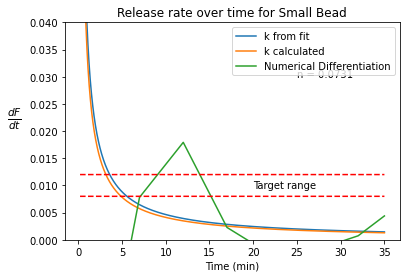

In [44]:
W2S = Week_2_small
small = np.array([[0,0]])
for i in range(0,8):
    idx = np.where(W2S[:,3*i+1] == np.max(W2S[:,3*i+1]))
    Point = W2S[idx,3*i:3*i+2]
    if Point.shape[1] == 2:
        Point = Point[:,0,:]
        Point - Point.reshape(1,2)
    else:
        Point = Point.reshape(1,2)
    small = np.vstack((small,Point))
small = small.reshape(9,2)
small_concen = (small[1:,1]/Conver.n)
small_concen_error = (small[1:,1]/Conver.s)
Mt_small = small_concen * 100
Minf_small = 2* 0.25 
F2 = Mt_small/Minf_small

Time2 = np.array([2,7,12,17,22,27,32,35])

Param_small,small_error = fit_linear(np.log(Time2),np.log(F2))

k_fit = np.exp(Param_small[1])
D = 60*4.9*10**-10 
diameter = ufloat(0.00244,0.0001044) 
radius = diameter/2
k_calc = 6*(D/(np.pi*radius**2))**(1/2)
k_calc=k_calc.n

n = Param_small[0]
n_error = small_error[0]

dFdt = data_deriv(F2,Time2)

f = lambda t: n*k_fit*t**(n-1) - 0.012
t1=so.fsolve(f,4)
f1 = lambda t: n*k_fit*t**(n-1) - 0.008
t2=so.fsolve(f1,5)
f2 = lambda t: n*k_calc*t**(n-1) - 0.012
t3=so.fsolve(f2,4)
f3 = lambda t: n*k_calc*t**(n-1) - 0.008
t4=so.fsolve(f3,5)

Time2_new = np.arange(0.2,35.01,0.01)
figure2 = plt.figure()
ax2 = figure2.add_subplot(111)
ax2.plot(Time2_new,k_fit*n*Time2_new**(n-1), label = 'k from fit')
ax2.plot(Time2_new,k_calc*n*Time2_new**(n-1),label = 'k calculated')
ax2.plot(Time2,dFdt,label = 'Numerical Differentiation')
ax2.plot(Time2_new,Time2_new*0+.012,c='red',linestyle='dashed')
ax2.plot(Time2_new,Time2_new*0+.008,c='red',linestyle='dashed')
ax2.annotate('Target range',(20,0.0095))
ax2.annotate('n = 0.0731',(25,0.03))
plt.xlabel('Time (min)')
plt.ylabel('$\\frac{dF}{dt}$',rotation=0,fontsize=15)
plt.title('Release rate over time for Small Bead')
plt.ylim(0,0.04)
ax2.yaxis.set_label_coords(-0.15,0.5)
plt.legend()

print(n,k_fit,k_calc)

0.2784085576342001 0.14531174527996044 0.4206015732694519


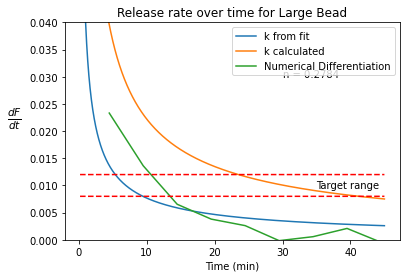

In [45]:
W2L = Week_2_large
large = np.array([[0,0]])
for i in range(0,9):
    idx = np.where(W2L[:,3*i+1] == np.max(W2L[:,3*i+1]))
    Point = W2L[idx,3*i:3*i+2]
    if Point.shape[1] == 2:
        Point = Point[:,0,:]
        Point - Point.reshape(1,2)
    else:
        Point = Point.reshape(1,2)
    large = np.vstack((large,Point))
large = large.reshape(10,2)
large_concen = (large[1:,1]/Conver.n)
Mt_large = large_concen * 100
Minf_large = 2* 0.5
F1 = Mt_large/Minf_large

Time1 = np.arange(4.5,45,5)

Param_large,large_error = fit_linear(np.log(Time1),np.log(F1))

k_fit = np.exp(Param_large[1])
D = 60*4.9*10**-10
diameter = ufloat(0.00276,0.0003625)
radius = diameter/2
k_calc = 6*(D/(np.pi*radius**2))**(1/2)
k_calc=k_calc.n

n = Param_large[0]
n_error = large_error[0]

dFdt = data_deriv(F1,Time1)

f = lambda t: n*k_fit*t**(n-1) - 0.012
t1=so.fsolve(f,4)
f1 = lambda t: n*k_fit*t**(n-1) - 0.008
t2=so.fsolve(f1,5)
f2 = lambda t: n*k_calc*t**(n-1) - 0.012
t3=so.fsolve(f2,4)
f3 = lambda t: n*k_calc*t**(n-1) - 0.008
t4=so.fsolve(f3,5)

Time1_new = np.arange(0.2,45.01,0.01)
figure1 = plt.figure()
ax1 = figure1.add_subplot(111)
ax1.plot(Time1_new,k_fit*n*Time1_new**(n-1), label = 'k from fit')
ax1.plot(Time1_new,k_calc*n*Time1_new**(n-1),label = 'k calculated')
ax1.plot(Time1,dFdt,label = 'Numerical Differentiation')
ax1.plot(Time1_new,Time1_new*0+.012,c='red',linestyle='dashed')
ax1.plot(Time1_new,Time1_new*0+.008,c='red',linestyle='dashed')
ax1.annotate('Target range',(35,0.0095))
ax1.annotate('n = 0.2784',(30,0.03))
plt.xlabel('Time (min)')
plt.ylabel('$\\frac{dF}{dt}$',rotation=0,fontsize=15)
plt.title('Release rate over time for Large Bead')
plt.ylim(0,0.04)
ax1.yaxis.set_label_coords(-0.15,0.5)
plt.legend()

print(n,k_fit,k_calc)

0.2208227449089593 0.30343261557438644 0.37326699106870975


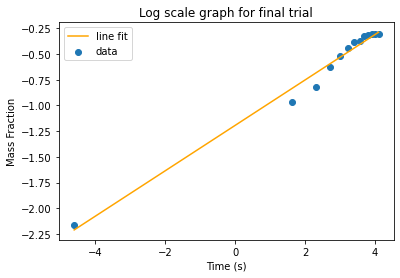

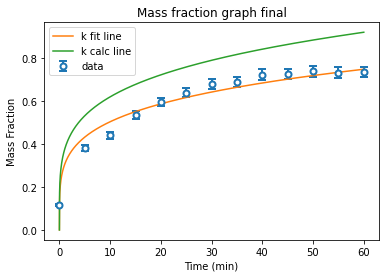

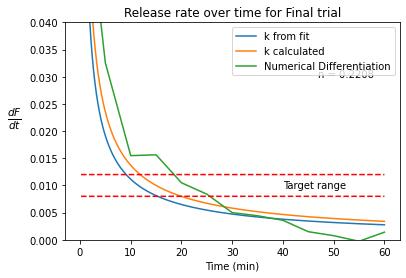

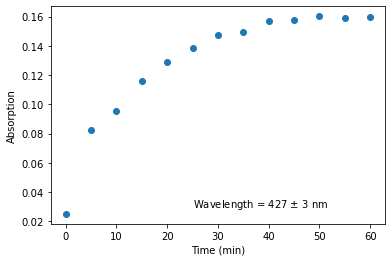

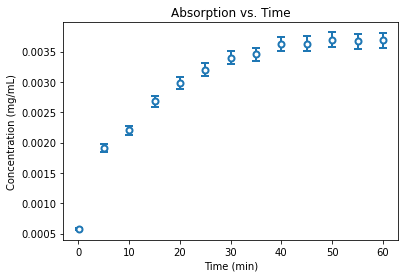

In [38]:
W3 = Week_3
final = np.array([[0,0]])
for i in range(0,13):
    W3_c = W3[:,3*i+1]
    W3_c = W3_c[~np.isnan(W3_c)]
    idx = np.where(W3[:,3*i+1] == np.max(W3_c))
    Point = W3[idx,3*i:3*i+2]
    if Point.shape[1] == 2:
        Point = Point[:,0,:]
        Point - Point.reshape(1,2)
    else:
        Point = Point.reshape(1,2)
    final = np.vstack((final,Point))
final = final.reshape(14,2)
final_concen = (final[1:,1]/Conver.n)
fe = (final[1:,1]/Conver)
Mt_final = final_concen * 100
Minf_final = 2* 0.25 
F3 = Mt_final/Minf_final

final_concen_error = np.array([fe[0].s,fe[1].s,fe[2].s,fe[3].s,fe[4].s,fe[5].s,fe[6].s,fe[7].s,fe[8].s,fe[9].s,fe[10].s,fe[11].s,fe[12].s])
Mt_final_error = final_concen_error * 100
F3e = Mt_final_error/Minf_final


Time3 = np.array([0.01,5,10,15,20,25,30,35,40,45,50,55,60])

Param_final,final_error = fit_linear(np.log(Time3),np.log(F3))

k_fit = np.exp(Param_final[1])
D = 60* 4.9*10**-10 
diameter = ufloat(0.00311,0.00026)
radius = diameter/2
k_calc = 6*(D/(np.pi*radius**2))**(1/2) 
k_calc=k_calc.n

n = Param_final[0]
n_error = final_error[0]


dFdt = data_deriv(F3,Time3)


plt.figure()
plt.scatter(np.log(Time3),np.log(F3),marker='o',label='data')
plt.plot(np.log(Time3),Param_final[0]*np.log(Time3)+Param_final[1],color='orange',label='line fit')
plt.xlabel('Time (s)')
plt.ylabel('Mass Fraction')
plt.title('Log scale graph for final trial')
plt.legend()

Time3_new = np.arange(0,60.01,0.01)

plt.figure()
plt.errorbar(Time3,F3,yerr=F3e,elinewidth=2,capsize=4,marker='o',linewidth=0,mew=2,mfc='white',label='data')
plt.plot(Time3_new,k_fit*Time3_new**n,label='k fit line')
plt.plot(Time3_new,k_calc*Time3_new**n,label='k calc line')
plt.xlabel('Time (min)')
plt.ylabel('Mass Fraction')
plt.title('Mass fraction graph final')
plt.legend()

f = lambda t: n*k_fit*t**(n-1) - 0.012
t1=so.fsolve(f,4)
f1 = lambda t: n*k_fit*t**(n-1) - 0.008
t2=so.fsolve(f1,5)
f2 = lambda t: n*k_calc*t**(n-1) - 0.012
t3=so.fsolve(f2,4)
f3 = lambda t: n*k_calc*t**(n-1) - 0.008
t4=so.fsolve(f3,5)

Time3_new = np.arange(0.2,60.01,0.01)
figure = plt.figure()
ax = figure.add_subplot(111)
ax.plot(Time3_new,k_fit*n*Time3_new**(n-1), label = 'k from fit')
ax.plot(Time3_new,k_calc*n*Time3_new**(n-1),label = 'k calculated')
ax.plot(Time3,dFdt,label = 'Numerical Differentiation')
ax.plot(Time3_new,Time3_new*0+.012,c='red',linestyle='dashed')
ax.plot(Time3_new,Time3_new*0+.008,c='red',linestyle='dashed')
ax.annotate('Target range',(40,0.0095))
ax.annotate('n = 0.2208',(47,0.03))
plt.xlabel('Time (min)')
plt.ylabel('$\\frac{dF}{dt}$',rotation=0,fontsize=15)
plt.title('Release rate over time for Final trial')
plt.ylim(0,0.04)
ax.yaxis.set_label_coords(-0.15,0.5)
plt.legend()

figure = plt.figure()
ax5 = figure.add_subplot(111)
ax5.scatter(Time3,final[1:,1])
ax5.annotate('Wavelength = 427 $\pm$ 3 nm',(25,0.03))
plt.xlabel('Time (min)')
plt.ylabel('Absorption',fontsize=10)

figure = plt.figure()
ax5 = figure.add_subplot(111)
ax5.errorbar(Time3,final_concen,yerr=final_concen_error,elinewidth=2,capsize=4,marker='o',linewidth=0,mew=2,mfc='white')
ax5.annotate('Wavelength = 427 $\pm$ 3 nm',(25,0.03))
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mg/mL)',fontsize=10)
plt.title('Absorption vs. Time')

print(n,k_fit,k_calc)